In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage import color, data, restoration
from IPython import display
import random
from lensless_demo_utils import *

In [2]:
import functools

In [3]:
def f(x,y):
    print(x*y)

funcy_tool = functools.partial(f, 2)
funcy_tool(8)

16


(2160, 2560, 3)
(1080, 1280, 3)


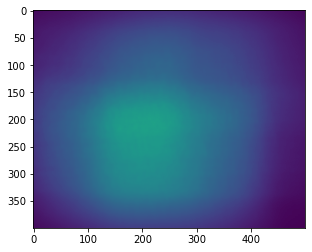

In [17]:
# this loads in the data. It will be replaced by simply loading in pre-processed mat files or equivalent.
tiff_bias = 100.;  
png_bias = 20;
#caustic_path = "/Users/nick.antipa/Documents/personal_webpage_html/antipa_files/hsvideo_code_with_data/hsvideo_public_data/PSF/psf_averaged_2018-12-5.tif"
caustic_path = "/Users/nick.antipa/Desktop/Desktop clean/MATLAB/caustics.tif"
kernel_raw = np.array(tiff.imread(caustic_path)).astype(np.float64) - tiff_bias

# Compute problem size based on caustics
kernel_size = np.shape(kernel_raw)
print(kernel_size)



# Load in raw data
#meas_path = "/Users/nick.antipa/Documents/PhD/Diffusers/HSVideoData/tennis_zip_ds/tennis_bounce_00043.tif"
#meas_path = "/Users/nick.antipa/Documents/PhD/Diffusers/HSVideoData/tennis_bounce_raw/tennis_bounce_00043.tif"
meas_path = "/Users/nick.antipa/Documents/PhD/Diffusers/Lensless/pco_2d_color/emrah_demosaic.tif"
#meas_path = "/Users/nick.antipa/Documents/PhD/Diffusers/Lensless/pco_2d_color/dog2.tif"



meas_raw = np.array(tiff.imread(meas_path)).astype(np.float64) - tiff_bias
meas_size = np.shape(meas_raw)
print(meas_size)


# Crop raw data and caustics

# Downsample problem
# Resize kernel



# rmin = 50*2
# rmax = 474*2
# cmin = 26*2
# cmax = 525*2
rmin = 80
rmax = 480
cmin = 70
cmax = 570
roi_select = lambda x:x[rmin:rmax,cmin:cmax,:]

psf = roi_select(im_downsample(kernel_raw,2))
psf = psf/np.sum(psf[:,:,1])
meas = roi_select(im_downsample(meas_raw,1))/65535.

[M,N,C] = np.shape(meas)


plt.figure()
plt.imshow(meas[:,:,1],vmax=1)


#kernel = np.array(Image.fromarray(kernel_crop).resize((img_dims[0]//2,img_dims[1]//2)))


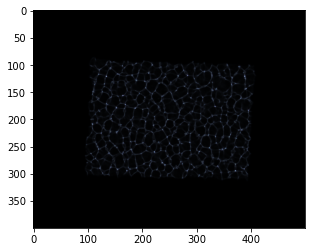

In [13]:
plt.imshow(np.maximum(psf/np.max(psf),0))

In [18]:
print(M)

400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


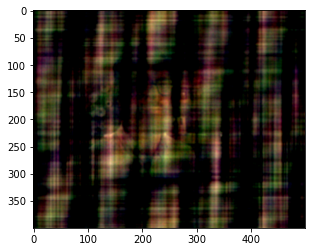

In [19]:
# Demonstrate Wiener deconvolution
recovered_wiener = np.zeros_like(meas)
for c in range(C):
    filtered, _ = restoration.unsupervised_wiener(meas[:,:,c], psf[:,:,c],clip=0)
    recovered_wiener[:,:,c] = filtered
    
plt.imshow(recovered_wiener/np.max(recovered_wiener))

We can see some of an object here, but there are a lot of artifacts. Why is this? Wiener deconvolution assumes a shift invariant system characterized by a single point spread function (PSF). A shift invariant system, $A$, satisfies the following $$b(\xi - u_0) = Ax(u - u_0)$$ where $b$ is the system output (sensor observation) and $x$ is the input (scene). There are two reasons why lensless cameras do not satisfy this property. The first is that discrete Fourier Transforms assume periodic signal extension. Cameras do not behave this way! If the input is shifted, we do not expect the PSF to wrap back around to the other side of the sensor. Below is an example showing how the PSF would behave with circular boundary conditions. You can see it is unphysical! PSFs don't wrap around when they shift off the sensor--they are cropped!

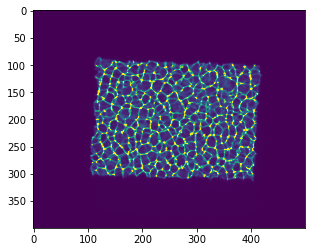

In [20]:
# Example showing input-output relationship and why this system is not invertible in freq. space
fig = plt.figure()
im_obj = plt.imshow(psf, vmax = .00005)
for shift_x in np.r_[0:500:10]:
#shift_x = 1000   #<--- play with this number to see how the PSF would behave
    shift_y = 0
    delta_scene = create_impulse((M,N),(shift_y,shift_x))
    test = fft_conv(delta_scene,psf[:,:,1])
    im_obj.set_data(test)  #plt.imshow(test,vmax = .000005)
    drawnow(fig)


The reason the Wiener filter fails is because this is not shift invariant, i.e., $$b(\xi - u_0) \neq Ax(u - u_0)$$ This means it cannot be modeled as a simple frequency space multiplication, breaking the assumptions that Wiener deconvolution relies upon.



The system is still linear, however. Let's solve the problem iteratively. We can do this using gradient descent. We can think of the scene we wish to recover as a vector, $\mathbf{x}$. A quick note on dimensions: we will think of the image as a vector, but we will not be reshaping it into a 1D vector when we implement these algorithms. The breakdown of how to solve these problems looks like this: 
1. Setup the optimization problem in terms of linear algebra
2. Factor the optical system matrix such that it can be computed using efficient operators
3. Derive the update equations in terms of these operators
4. Implement the iterative solver.

Let's see this in action. 

### Step 1: Setup the optimization problem in terms of linear algebra
So far we have expressed the forward model in signal processing terms $$b = \mbox{crop}\left[x * \mbox{pad}(h)\right]$$

This can be written in terms of FFT convolution

$$b = \mbox{crop}\left\{F^{-1}[F(x) \cdot F(S^{-1}\bar{h})]\right\}$$

where $F$ is the 2D Fast Fourier Transform (FFT),  $S$ is FFT shifting, and $\circ$ denotes the hadamard product (elementwise multiplication of two vectors). Here we think of $b$, $x$, and $h$ as 2D signals. For simplicity, we are treating these as discrete signals and assuming they are well approximated as such. 


An alternate way of expressing this problem is to use linear algebra. This is useful for connecting our problem to convex optimization and makes deriving gradients easy. Because each operation in our forward model is linear, we can equivalently write the forward model as $$\mathbf{b}=A\mathbf{x}.$$

Here, $\mathbf{x}$ contains the same values as $x$, but we are using bold to denote that this is a vector. You can think of this as a column-stacked 1D version of $x$. So if $x\in \mathbb{R}^{M\times N}$, then $\mathbf{x}\in \mathbb{R}^{MN\times 1}$. Equivalently, we can think of $\mathbf{x}$ as a vector that is indexed with two arguments, the row and column indices $m$ and $n$, respectively (there's no reason a vector space requires vectors to be 1D!). $A$ is the optical system matrix and it maps from object space to sensor space. Column $i$ of $A$, $\mathbf{a}_i$, is a vector which represents the sensor intensity distribution from scene point indexed by $i$. 

We can then find an estimate of the image by solving an optimization problem \begin{equation}\hat{\mathbf{x}}=\arg\min_x \frac{1}{2}\|A\mathbf{x} - \mathbf{b}\label{eq:1} \tag{1}\|_2^2\end{equation}

If we knew $A$ in its entirety, we could solve this either by direct matrix inversion, or iteratively. However, because we want to recover images with a reasonable number of pixels, $A$ is too large to handle explicitly (a 1 megapixel sensor would require $A$ to contain approximately 1 million 1 megapixel images!). To get around this problem, lensless cameras employ optical designs that lead to system matrices that can be efficently computed. In our case, we will use the convlutional nature of our camera to achieve this. What we'll do is use the linear algebra representation to analyze the problem and derive iterative updates, but when we implement it in code, we will use operators and functions that are more efficient than a large matrix multiply.

We're going to focus on solving this problem iteratively. We start by solving Eq. $\ref{eq:1}$ using gradient descent. This can be done using the update equations

\begin{equation}x^{k+1} \leftarrow x^k - \mu A^H(A\mathbf{x} - \mathbf{b}) \label{eq:gd_update}\tag{2}\end{equation}

where $A^H$ is the adjoint (conjugate-transpose) of $A$.

### Step 2: Factor the optical system matrix such that it can be computed using efficient operators. 
Since we introduced the forward model in terms of signal processing, we'll take each operator and think about what its equivalent matrix representation looks like. We can then use this to compute the above gradient. Since each operator in our forward model is linear, we'll denote each with a matrix. $P$ denotes zero padding, $C$ denotes cropping, and $H$ denotes 2D circular convolution with the padded PSF, $\bar{h}$. Hence we can write 
\begin{aligned}Ax &= CF^{-1}\left[FS^{-1}h\circ Fx)\right]\\& = CF^{-1}\mbox{diag}(\tilde{H})Fx\end{aligned} 

The operator $\circ$ is the hadamard product (elementwise multiplication between two vectors), which we can equivalently express as $x\circ y = \mbox{diag}(x)y$ where $\mbox{diag}(x)$ is a matrix with the elements of $x$ on the diagonal. 

Now it is easy to derive an expression for $A^H$ so that we can easily compute our gradient. Using a few simple properties, this is straightforward:

1. $(ABC)^H = C^HB^HA^H$
2. FFTs are unitary, so $F^H = F^{-1}$. 
3. The adjoint of cropping is zero padding, so $C^H = P$ where $P$ is zero padding
4. $diag(x)^H = diag(x^*)$ where $x^*$ is elementwise complex conjugation

This gives us an adjoint which is

$$\begin{aligned}A^H &= F^H \mbox{diag}\left(\tilde{H} \right)^HF^{-H}C^H\\ &= F^{-1}\mbox{diag}\left(\tilde{H}^* \right)FP \end{aligned}$$. 



In signal processing terms, we note that conjugation in frequency space is equivelent to mirroring in real space, so computing the adjoint of our system, $A^H$, is equivalent to zero padding followed by circular convolving with the mirrored PSF (this is circular correlation!).

### Step 3: Derive the update equations in terms of these operators

Now that we've got this expression for $A$, we can rewrite the gradient update \ref{eq:gd_update} in terms of our operators. We'll need a few properties to get this done:


$$\mathbf{x}^{k+1} \rightarrow x^k - \mu F^H \mbox{diag}\left(\tilde{H}^* \right)FP\left[CF^{H}\mbox{diag}\left(\tilde{H}\right)Fx^k - b\right]$$

In signal processing notation, this would be

$$x^{k+1} \rightarrow x^k - \mu \bar{h}\star \mbox{pad}\left[\mbox{crop}\left(\bar{h}\circledast x - b \right)\right]$$









The beauty of this is that we can implement each one of these linear operators more efficiently than using explicit matrices and vectorizing the image.

| matrix      | Numpy |
| ----------- | ----------- |
| $Fx$     | `np.fft.fft2(ifftshift(x))`     |
| $F^{-1}y$   | `fft.fftshift(fft.ifft2(y))`        |
| $\mbox{diag}(x) y$   | `x*y`    |
| crop($x$) | `x[M//4:5*M//4, N//4:5*M//4]`|
| pad($x$) | `pad(x,[(M//2,M//2), (N//2,N//2)],'constant')`|


Below are the main functions for computing our gradients. They are defined here for readability

In [21]:
def F(x):
    return fft2(x,axes=(0,1))

In [22]:
def Fh(x):
    return ifft2(x,axes=(0,1))

In [23]:
def crop(x):
    M,N,_ = x.shape
    rl = M//4
    ru = 3*np.ceil(M/4)
    cl = N//4
    cu = 4*np.ceil(N/4)
    return x[M//4:3*M//4, N//4:3*N//4]

In [24]:
def pad(x):
    M,N,_ = x.shape    
    return np.pad(x,[(M//2,M//2), (N//2,N//2),(0,0)],'constant')

In [25]:
recovered_wiener_pad = np.zeros_like(pad(meas))
meas_pad = pad(meas)
psf_pad = pad(psf)
for c in range(C):
    filtered, _ = restoration.unsupervised_wiener(meas_pad[:,:,c], psf_pad[:,:,c],clip=0)
    recovered_wiener_pad[:,:,c] = filtered
    print(np.shape(filtered))

(800, 1000)
(800, 1000)
(800, 1000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


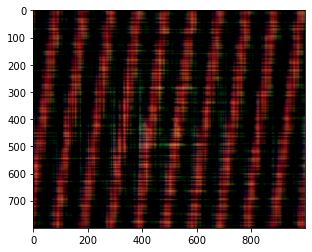

In [26]:
plt.imshow(recovered_wiener_pad/np.max(recovered_wiener_pad))

In [27]:
# Our forward model is then going to be
H = F(ifftshift(pad(psf)))
H_star = np.conj(H)

def A(x):
    return np.real(crop(Fh(F(x)*H)))

def Ah(y):
    return np.real(Fh(H_star*F(pad(y))))


In [28]:
x = np.random.rand(2*M, 2*N,C)
y = np.random.rand(M,N,C)

Ax_y = np.sum(A(x)*y)
x_Ahy = np.sum(x*Ah(y))
print('<A(x),y> =',Ax_y)
print('<x,Ah(y)>=',x_Ahy)

<A(x),y> = 158439.4752141166
<x,Ah(y)>= 158439.4752141166


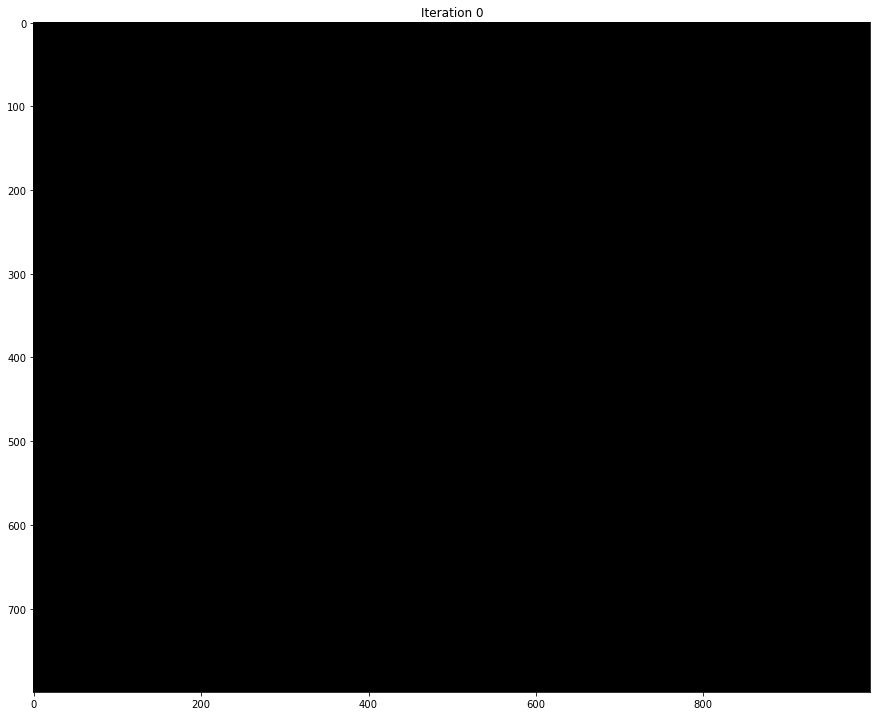

In [29]:
n_iters = 500   #Number of iterations
x_k = np.zeros((2*M, 2*N,C))   #Initialize with zeros
mu = 1    #Step size

fig = plt.figure(figsize=(15,15))   #Initialize figure
im_obj = plt.imshow(x_k)    
title_obj = plt.title('Iteration {}'.format(0))

KeyboardInterrupt: 

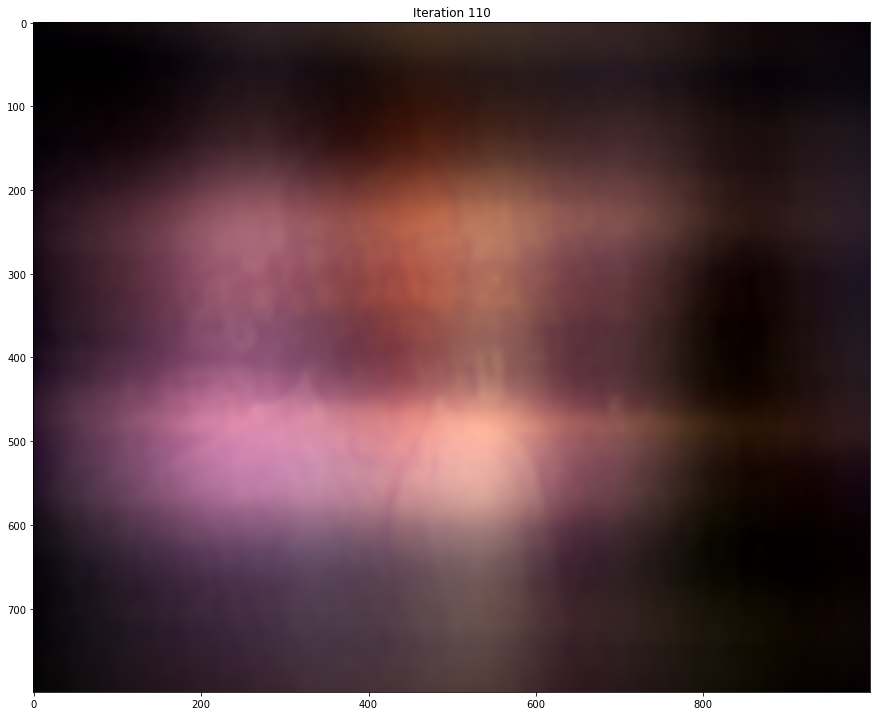

In [30]:
# Gradient descent 
n_iters = 500   #Number of iterations
x_k = np.zeros((2*M, 2*N,C))   #Initialize with zeros
mu = 1    #Step size

fig = plt.figure(figsize=(15,15))   #Initialize figure
im_obj = plt.imshow(x_k)  
#im_update = update(im_obj, fig, )
title_obj = plt.title('Iteration {}'.format(0))

for k in range(n_iters):
    x_k = x_k - mu*Ah(A(x_k) - meas)    #Gradient update
    
    # Display progress
    if k%10 == 0:
        im_obj.set_data(np.maximum(crop(x_k)/np.max(x_k),0))
        plt.title('Iteration {}'.format(k))
        drawnow(fig)

x_gd = x_k

im_obj.set_data(np.maximum(crop(x_k)/np.max(x_k),0))
plt.title('Iteration {}'.format(k))

KeyboardInterrupt: 

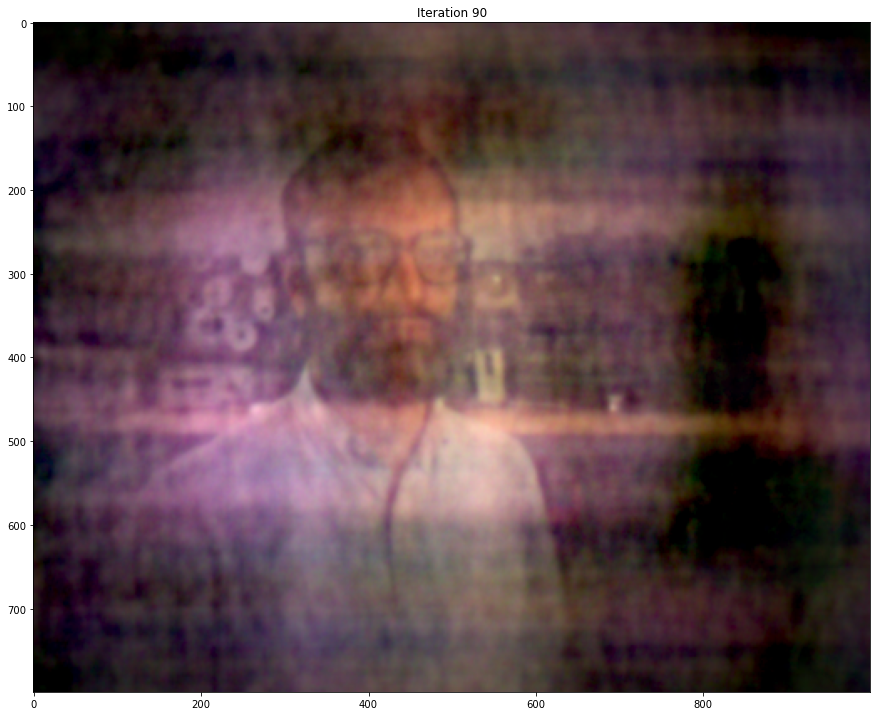

In [31]:
# FISTA with nonnegativity only
n_iters = 500

gam = 1/1.5

# Initialize variables
t_k = 1    #Momentum parameter
x_k = np.zeros((2*M, 2*N, C))   # Image
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
mu = 1   #Step size

# Initialize plotting
fig = plt.figure(figsize=(15,15))
im_obj = plt.imshow(x_k)    
title_obj = plt.title('Iteration {}'.format(0))


for k in range(n_iters):
    # Update momentum parameters
    t_kp = (1+np.sqrt(1+4*t_k**2))/2
    beta = (t_k-1)/t_kp
    
    # Gradient update
    z_k = y_k - mu*Ah(A(y_k) - meas)
    
    # Project onto nonnegative set
    x_kp = np.maximum(z_k,0)
    
    # Apply momentum
    y_k = x_kp + beta*(x_kp - x_k)

    # Remember values for next iteration
    x_k = x_kp
    t_k = t_kp
    
    if k%10 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**(gam))
        plt.title('Iteration {}'.format(k))
        drawnow(fig)

x_fista = y_k 

In [32]:
def soft_thresh( x, tau):
    out = np.maximum(np.abs(x)- tau, 0)
    out = out*np.sign(x)
    return out 

def tv2d_aniso_haar(x,tau,plot=0): 
    #we average the sum of shrinkage function in each direction
    #first, we transform the image using wavelet like opeartions to LL and HL, low res image and details of one direction
    #we soft threshold this, then we do the same for the other direction. 
    D=2;  #dimensions
    gamma=1; #stepsize
    thresh=np.sqrt(2)*2*D*tau*gamma; #this is the threshold for the shrinkage function
    y=np.zeros_like(x)
    for axis in range (0,2):
        y=y+iht2(ht2(x,axis,'false',thresh),axis,'false')
        y=y+iht2(ht2(x,axis,'true',thresh),axis,'true')
    y=y/(2*D)
    if (plot==1):
        ax1=plt.subplot(1,1,1)
        ax1.clear()
        im1=ax1.imshow(y,vmax=0.1)
        display.clear_output(wait=True)
        display.display(pl.gcf())

        time.sleep(0.02) 
        
    loss=np.gradient(y)
    loss=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))        
    return y#,loss

def tv2d_aniso_haar_rgb(x,tau,plot=0): 
    #we average the sum of shrinkage function in each direction
    #first, we transform the image using wavelet like opeartions to LL and HL, low res image and details of one direction
    #we soft threshold this, then we do the same for the other direction. 
    D=2;  #dimensions
    gamma=1; #stepsize
    thresh=np.sqrt(2)*2*D*tau*gamma; #this is the threshold for the shrinkage function
    y=np.zeros_like(x)
    for axis in range (0,2):
        y=y+iht2_rgb(ht2_rgb(x,axis,'false',thresh),axis,'false')
        y=y+iht2_rgb(ht2_rgb(x,axis,'true',thresh),axis,'true')
    y=y/(2*D)
    if (plot==1):
        ax1=plt.subplot(1,1,1)
        ax1.clear()
        im1=ax1.imshow(y,vmax=0.1)
        display.clear_output(wait=True)
        display.display(pl.gcf())

        time.sleep(0.02) 
        
    loss=np.gradient(y)
    loss=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))        
    return y#,loss

def ht2(x,ax,shift,thresh): #only works for even dimensions
    s=np.shape(x)
    w=np.zeros_like(x)
    D=1/np.sqrt(2)
    if shift=='true':
        x=np.roll(x,-1,axis=ax) #shifts x by one pixel in axis ax
    m=int(np.floor(s[ax]/2))
    if ax==0:
        w[0:m,:]=D*(x[1::2,:]+x[0::2])
        w[m::,:]=soft_thresh(D*(x[1::2]-x[0::2]),thresh) #shrinkage operation
    elif ax==1:
        w[:,0:m]=D*(x[:,1::2]+x[:,0::2])
        w[:,m::]=soft_thresh(D*(x[:,1::2]-x[:,0::2]),thresh) #shrinkage operation
        
    
    return w

def ht2_rgb(x,ax,shift,thresh): #only works for even dimensions
    s=np.shape(x)
    w=np.zeros_like(x)
    D=1/np.sqrt(2)
    if shift=='true':
        x=np.roll(x,-1,axis=ax) #shifts x by one pixel in axis ax
    m=int(np.floor(s[ax]/2))
    if ax==0:
        w[0:m,:]=D*(x[1::2,:]+x[0::2,:])
        w[m::,:]=soft_thresh(D*(x[1::2,:,:]-x[0::2,:,:]),thresh) #shrinkage operation
    elif ax==1:
        w[:,0:m]=D*(x[:,1::2,:]+x[:,0::2,:])
        w[:,m::]=soft_thresh(D*(x[:,1::2,:]-x[:,0::2,:]),thresh) #shrinkage operation
        
    
    return w


def iht2(w,ax,shift):
    s=np.shape(w)
    y=np.zeros_like(w)
    D=1/np.sqrt(2)
    m=int(np.floor(s[ax]/2))
    if ax ==0:
        y[0::2,:]=D*(w[0:m,:]-w[m::,:]) #even part
        y[1::2,:]=D*(w[0:m,:]+w[m::,:])#odd part
    
    elif ax==1:
        y[:,0::2]=D*(w[:,0:m]-w[:,m::]) #even part
        y[:,1::2]=D*(w[:,0:m]+w[:,m::])#odd part
        
    if shift=='true':
        y=np.roll(y,1,axis=ax)
    return y

def iht2_rgb(w,ax,shift):
    s=np.shape(w)
    y=np.zeros_like(w)
    D=1/np.sqrt(2)
    m=int(np.floor(s[ax]/2))
    if ax ==0:
        y[0::2,:]=D*(w[0:m,:,:]-w[m::,:,:]) #even part
        y[1::2,:]=D*(w[0:m,:,:]+w[m::,:,:])#odd part
    
    elif ax==1:
        y[:,0::2]=D*(w[:,0:m,:]-w[:,m::,:]) #even part
        y[:,1::2]=D*(w[:,0:m,:]+w[:,m::,:])#odd part
        
    if shift=='true':
        y=np.roll(y,1,axis=ax)
    return y

KeyboardInterrupt: 

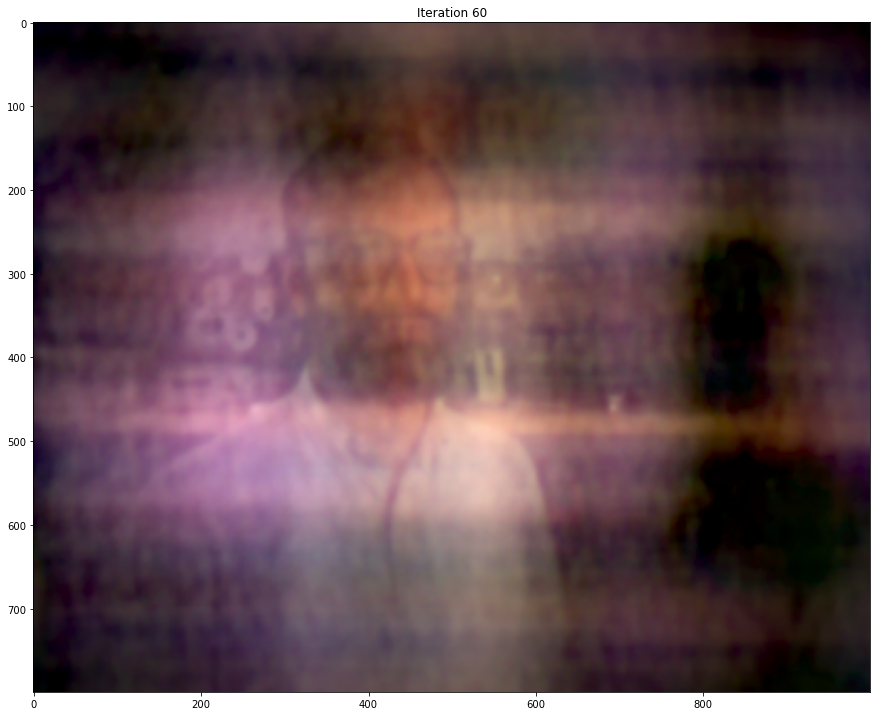

In [33]:
# FISTA with Total Variation
n_iters = 400

# Initialize variables
t_k = 1    #Momentum parameter
x_k = np.zeros((2*M, 2*N, C))   # Image
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
mu = 1   #Step size
tau_tv = 10e-6    #Denoising parameter  

# Initialize plotting
fig = plt.figure(figsize=(15,15))
im_obj = plt.imshow(x_k)    
title_obj = plt.title('Iteration {}'.format(0))


for k in range(n_iters):
    # Update momentum parameters
    t_kp = (1+np.sqrt(1+4*t_k**2))/2
    beta = (t_k-1)/t_kp
    
    # Gradient update
    z_k = y_k - mu*Ah(A(y_k) - meas)
    
    # Apply TV denoising
    x_kp = 0.5*np.maximum(z_k,0) + 0.5*tv2d_aniso_haar(z_k, tau_tv)
    
    # Apply momentum
    y_k = x_kp + beta*(x_kp - x_k)

    # Remember values for next iteration
    x_k = x_kp
    t_k = t_kp
    
    # Display progress
    if k%10 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**(gam))
        plt.title('Iteration {}'.format(k))
        drawnow(fig)

x_fista = y_k 

In [34]:
def apply_gamma(x,gam):
    xmx = np.max(x)
    out = xmx*(x/xmx)**gam
    return out

def RGB2YPbPr(x):
    Kr = .299
    Kg = .587
    Kb = .114
    R = x[:,:,0]
    G = x[:,:,1]
    B = x[:,:,2]
    Y = Kr*R + Kg*G + Kb*B
    Pb = -Kr/(2*(1-Kb))*R - Kg/(2*(1-Kb))*G + B/2
    Pr = R/2 - Kg/(2*(1-Kr))*G - Kb/(2*(1-Kr))*B
    return Y, Pb, Pr

def YPbPr2RGB(Y, Pb, Pr):
    Kr = .299
    Kg = .587
    Kb = .114
    R = Y + (2-2*Kr)*Pr
    G = Y - Kb*(2 - 2*Kb)/Kg*Pb - Kr*(2-2*Kr)/Kg*Pr
    B = Y + (2 - 2*Kb)*Pb
    return np.stack([R,G,B],axis=2)



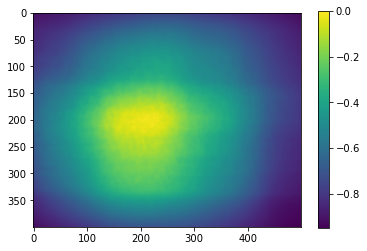

In [35]:
meas_gam = np.real(apply_gamma(meas,1/2))
Y, Pb, Pr = RGB2YPbPr(meas)
Y_denoised = tv2d_aniso_haar(Y, .00001)
RGB = YPbPr2RGB(Y_denoised, Pb, Pr)
meas_degam = np.real(apply_gamma(meas, 2))

plt.imshow((meas_degam[:,:,0] - meas[:,:,0])/meas[:,:,0])
plt.colorbar()

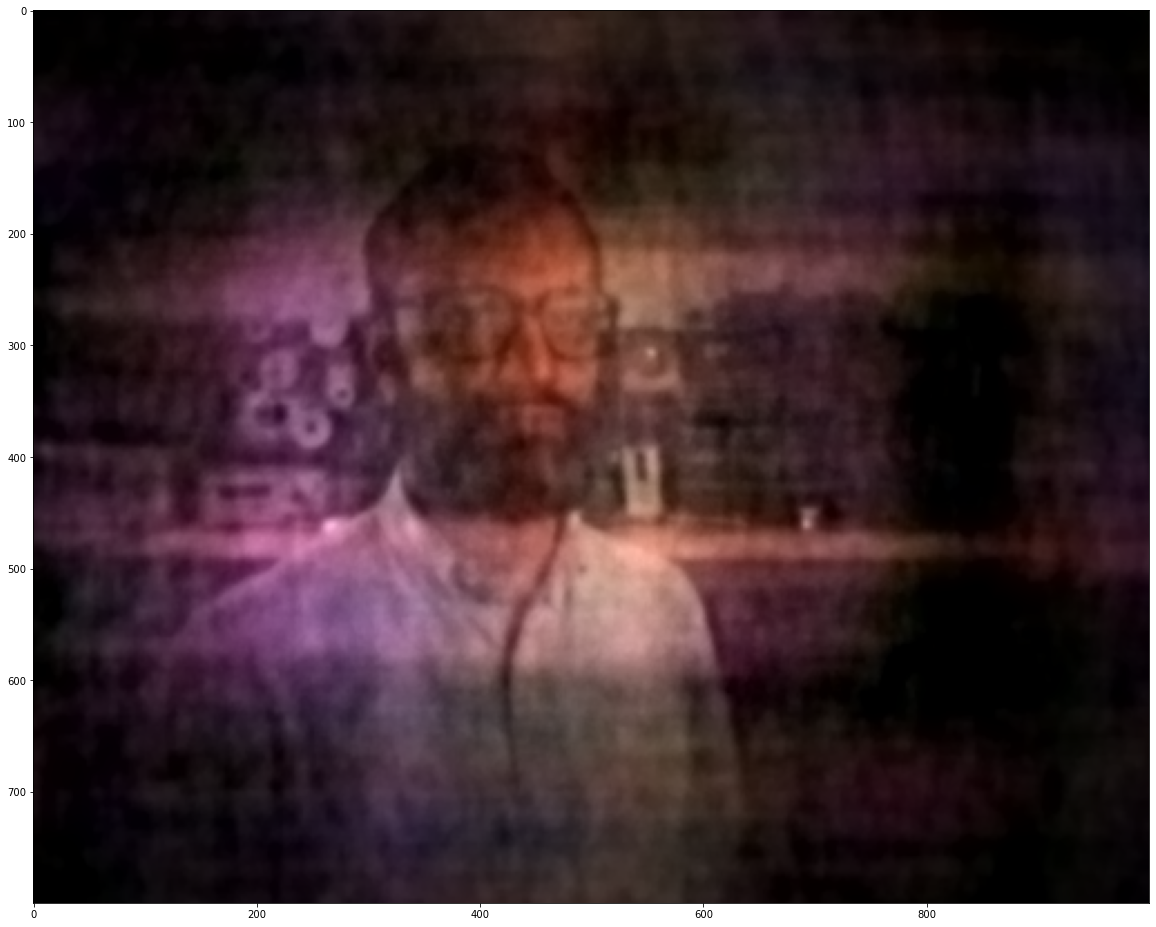

In [ ]:
# Luminance
fig = plt.figure(figsize=(20,20))
t_k = 1
x_k = np.zeros((2*M, 2*N, C))
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
mu = 1
n_iters = 500
tau_tv = 3e-6

# For "medium" res:
# mu = 1
# n_iters = 500
# tau_tv = 3e-6

im_obj = plt.imshow(x_k)
gam = 1
for k in range(n_iters):

    t_kp = (1+np.sqrt(1+4*t_k**2))/2;
   
    beta = (t_k-1)/t_kp;
    
    z_k = y_k - mu*Ah(A(y_k) - meas)
    
    
    z_gam = np.real(apply_gamma(z_k+0j,gam))
    Y, Pb, Pr = RGB2YPbPr(z_gam)
    
    Y_k = tv2d_aniso_haar(Y, tau_tv)
    Pb_k = tv2d_aniso_haar(Pb, tau_tv*400)
    Pr_k = tv2d_aniso_haar(Pr, tau_tv*400)
    
    RGB= np.real(apply_gamma(YPbPr2RGB(Y_k, Pb_k, Pr_k)+0j,1/gam))
    
    
    x_kp = 0.5*RGB + 0.5*np.maximum(z_k,0)
    y_k = x_kp + beta*(x_kp - x_k)

    x_k = x_kp
    
    
    t_k = t_kp
   
    
    if k%10 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**(gam))
        drawnow(fig)

x_fista = y_k 

In [ ]:
fig = plt.figure(figsize=(20,20))
t_k = 1
x_k = np.zeros((2*M, 2*N, C))
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
mu = 1
n_iters = 500
tau_tv = 24e-6

im_obj = plt.imshow(x_k)

for k in range(n_iters):
    t_kp = (1+np.sqrt(1+4*t_k**2))/2;
    beta = (t_k-1)/t_kp;
    
    z_k = y_k - mu*Ah(A(y_k) - meas)
    x_kp = 0.5*tv2d_aniso_haar(z_k, tau_tv) + 0.5*np.maximum(z_k,0)
    y_k = x_kp + beta*(x_kp - x_k)

    x_k = x_kp
    t_k = t_kp
    
    if k%10 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**(gam))
        drawnow(fig)

x_fista = y_k 

In [ ]:
#Let's do a toy compressed sensing problem. We're going to delete pixels at random and recover the object
live_pct = 15
N_live = ((100-live_pct)*M*N)//100
dead_pixels = random.sample(range(0,M*N),N_live)
                            
# Select random pixels to destroy

# destroy them

# modify our gradient

# repeat inverse problem



In [ ]:
plt.figure(figsize=(20,20))
r = meas[:,:,0].ravel()
g = meas[:,:,1].ravel()
b = meas[:,:,2].ravel()

mask_vec = np.ones_like(r)
mask_vec[dead_pixels] = 0

r[dead_pixels] = 0
g[dead_pixels] = 0
b[dead_pixels] = 0

meas_erased = np.zeros_like(meas)
meas_erased[:,:,0] = np.reshape(r, (M,N))
meas_erased[:,:,1] = np.reshape(g, (M,N))
meas_erased[:,:,2] = np.reshape(b, (M,N))
mask = np.tile(np.reshape(mask_vec, (M,N,1)), [1,1,3])
plt.imshow(mask)




In [ ]:
Nrows = M*(100-live_pct)//100
rs = random.sample(range(0,M),Nrows)
meas_test = 1.*meas
r = np.ones((M,1))
r[rs] = 0
msk = np.tile(np.expand_dims(np.outer(r,np.ones((N,1))),-1)  ,[1,1,3])
#meas_test[rs,:] = 0
#plt.figure(figsize=(20,20))
#plt.imshow(msk)a
meas2 = msk*meas_test
plt.imshow(meas2*10)

We can model this forward model similarly to before: $$\mathbf{b} = D A\mathbf{x}$$
where $D$ is a diagonal matrix that is equal to 1 when a pixel is live, and 0 when a pixel has been erased. Our gradient is then $A^\intercal D(D A\mathbf{x} - \mathbf{b})$. We can capture this by changing our forward and adjoint operators

In [ ]:
A = lambda x: mask*np.real(crop(Fh(F(x)*H)))
Ah = lambda y: np.real(Fh(H_star*F(pad(mask*y))))

In [ ]:
t_k = 1
x_k = np.zeros((2*M, 2*N, C))
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
mu = 5
n_iters = 2000
tau_tv = 10e-6

# Good parameters: 10% with tau_tv = 10e-6, 2x ds, mu = 12
tau_k = np.logspace(-3,-5,n_iters)

fig = plt.figure(figsize=(20,20))
im_obj = plt.imshow(x_k)

for k in range(n_iters):
    t_kp = (1+np.sqrt(1+4*t_k**2))/2;
    beta = (t_k-1)/t_kp;
    
    x_kp = y_k - mu*Ah(A(y_k) - meas_erased)
    #x_kp = 0.5*tv2d_aniso_haar(z_k, tau_tv*mu) + 0.5*np.maximum(z_k,0)
    y_k = x_kp + beta*(x_kp - x_k)

    x_k = x_kp
    t_k = t_kp
    
    if k%5 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**gam)
        drawnow(fig)

x_fista = y_k 

In [ ]:

t_k = 1
x_k = np.zeros((2*M, 2*N, C))
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
mu = 5
n_iters = 1000
tau_tv = 20e-6

# Good parameters: 10% with tau_tv = 10e-6, 2x ds, mu = 12
tau_k = np.logspace(-3,-6,n_iters)

fig = plt.figure(figsize=(20,20))
im_obj = plt.imshow(x_k)

gam = 1/1.5

for k in range(n_iters):
    t_kp = (1+np.sqrt(1+4*t_k**2))/2;
    beta = (t_k-1)/t_kp;
    
    z_k = y_k - mu*Ah(A(y_k) - meas_erased)
    
    
    z_gam = np.real(apply_gamma(z_k+0j,gam))
    Y, Pb, Pr = RGB2YPbPr(z_gam)
    
    Y_k = tv2d_aniso_haar(Y, tau_tv)
    Pb_k = tv2d_aniso_haar(Pb, tau_tv*4)
    Pr_k = tv2d_aniso_haar(Pr, tau_tv*4)
    
    RGB= np.real(apply_gamma(YPbPr2RGB(Y_k, Pb_k, Pr_k)+0j,1/gam))
    
    x_kp = 0.5*RGB + 0.5*np.maximum(z_k,0)
    y_k = x_kp + beta*(x_kp - x_k)
    
    
    x_k = 1.0*x_kp
    t_k = 1.0*t_kp
    
    if k%5 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**gam)
        drawnow(fig)

x_fista = y_k 

In [ ]:
# Good parameters: 10% with tau_tv = 10e-6, 2x ds, mu = 12

In [ ]:
# Solve the sparse recovery problem

#Initialize everything
t_k = 1
x_k = np.zeros((2*M, 2*N, C))
z_k = np.zeros((2*M, 2*N, C))
y_k = np.zeros((2*M, 2*N, C))
fig = plt.figure(figsize=(15,15))
im_obj = plt.imshow(x_k)

mu = 5   # Set step size
n_iters = 1000   #Number of iterations
tau_tv = 5e-6    #Sparsity parameter (higher = more denoising)

for k in range(n_iters):
    # Update momentum
    t_kp = (1+np.sqrt(1+4*t_k**2))/2;   
    beta = (t_k-1)/t_kp;
    
    # Apply gradient update
    z_k = y_k - mu*Ah(A(y_k) - meas_erased)
    
    # Denoise the result
    x_kp = 0.5*tv2d_aniso_haar(z_k, tau_tv*mu) + 0.5*np.maximum(z_k,0)
    
    # Apply momentum
    y_k = x_kp + beta*(x_kp - x_k)
    
    # Update iterative variables
    x_k = x_kp
    t_k = t_kp
    
    # Display progress
    if k%5 == 0:
        im_obj.set_data((np.maximum(crop(y_k)/np.max(y_k),0))**gam)
        drawnow(fig)

x_fista = y_k   #Remember result